# 프로젝트: Seq2Seq로 한-영 번역기 만들기

## 목차:  
STEP 0. 패키지 & 데이터 로드  
STEP 1. EDA & 데이터 전처리  
STEP 2. 모델 설계  
STEP 3. 모델 학습  
STEP 4. 시각화 & 결과 해석  
회고

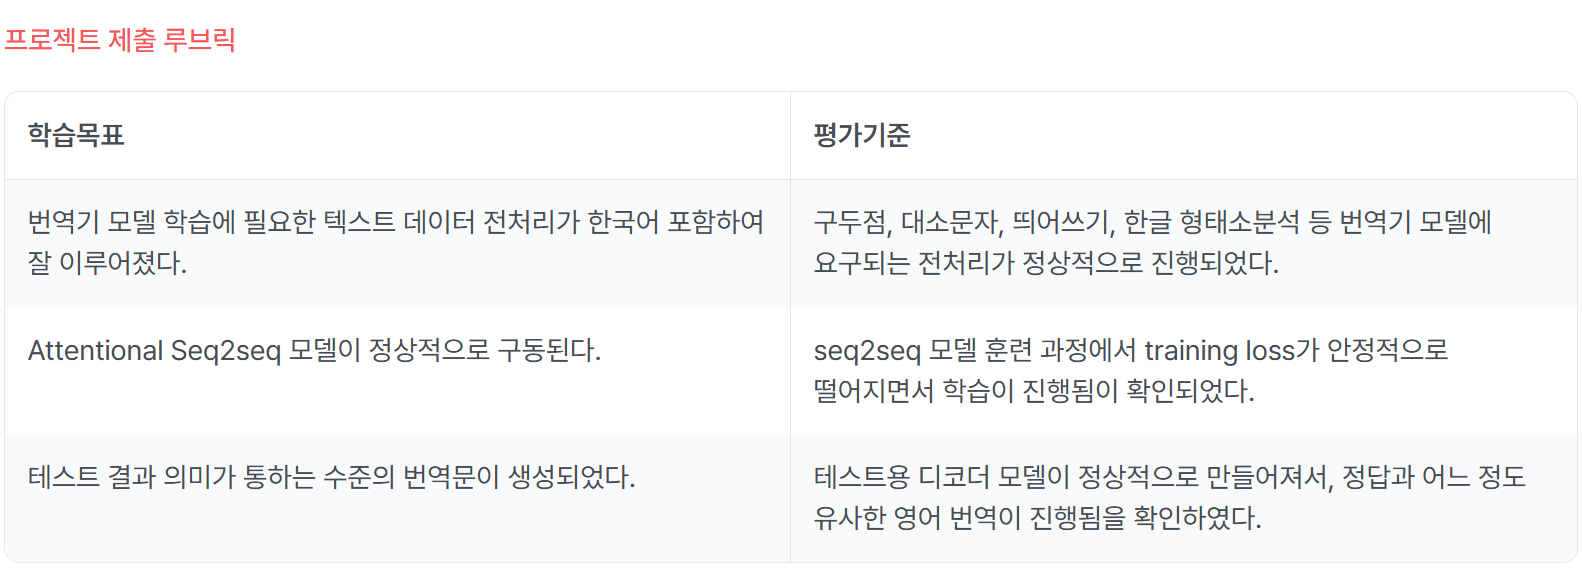

# STEP 0. 라이브러리 & 데이터 로드

## 폰트 설정

In [ ]:
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,793 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


## 사용할 라이브러리

In [ ]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.8.0+cu126


## 데이터 다운로드

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04"

/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04


In [ ]:
dataset_dir = os.path.join(os.path.expanduser("./data"), "spa-eng")
os.makedirs(dataset_dir, exist_ok=True)
zip_path = os.path.join(dataset_dir, "spa-eng.zip")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

data_folder = os.path.join(dataset_dir, "spa-eng")
if not os.path.exists(data_folder):
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(data_folder, "spa.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))

데이터 다운로드 중...
다운로드 완료!
압축 해제 중...
압축 해제 완료!
데이터셋 디렉토리: ['spa-eng.zip', 'spa-eng']


# STEP 1. EDA & 전처리

## EDA

In [ ]:
# 샘플 확인
df = pd.read_csv(path_to_file, sep = "\t", names = ["eng", "spa"])
print(len(df))
df.head()

118964


,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [ ]:
# 중복 확인
print(df.duplicated().sum())

# 결측치 확인
print(df.isna().sum())

0
eng    0
spa    0
dtype: int64



=== 길이 통계 ===
        eng_len_char   spa_len_char   eng_len_word   spa_len_word
count  118964.000000  118964.000000  118964.000000  118964.000000
mean       31.556958      33.003530       6.310363       6.083874
std        13.237459      14.592399       2.611586       2.764453
min         3.000000       3.000000       1.000000       1.000000
25%        22.000000      23.000000       4.000000       4.000000
50%        29.000000      30.000000       6.000000       6.000000
75%        38.000000      40.000000       8.000000       7.000000
max       247.000000     278.000000      47.000000      49.000000


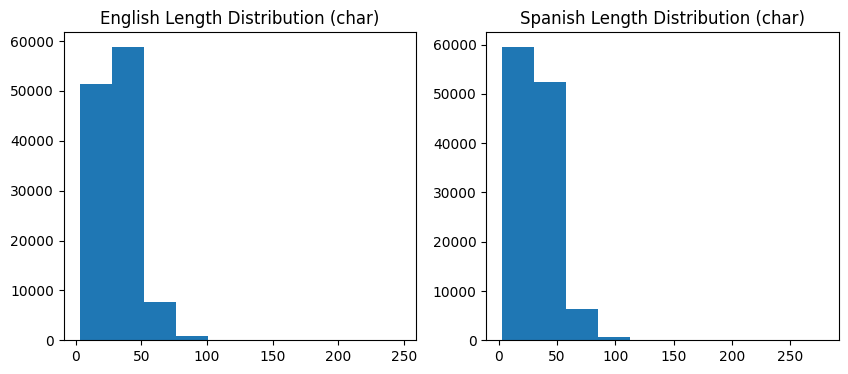



=== 중복 개수 ===
영어 문장 중복: 16060
스페인어 문장 중복: 5642


=== 어휘 통계 ===
영어 어휘 수: 18337
스페인어 어휘 수: 33948

상위 영어 토큰: [('I', 27298), ('to', 26385), ('the', 22552), ('Tom', 19315), ('you', 17356), ('a', 17242), ('is', 13516), ('in', 8661), ('of', 8249), ('was', 7062)]
상위 스페인어 토큰: [('de', 22521), ('que', 21277), ('a', 18808), ('Tom', 18714), ('la', 15208), ('en', 12223), ('el', 11706), ('no', 10725), ('es', 10371), ('un', 9731)]


=== 특수문자/문장부호 종류 ===
영어 문장에서 등장한 특수문자: ['!', '"', '$', '%', "'", '+', ',', '-', '.', '/', ':', ';', '?', '°', '‘', '’', '€']
스페인어 문장에서 등장한 특수문자: ['!', '"', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', ':', ';', '?', '¡', '¨', '«', '°', '»', '¿', '\u200b', '—', '€']
전체에서 등장한 특수문자: ['!', '"', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', ':', ';', '?', '¡', '¨', '«', '°', '»', '¿', '\u200b', '—', '‘', '’', '€']

영어의 non-alnum 문자: ['!', '"', '$', '%', "'", '+', ',', '-', '.', '/', ':', ';', '?', '°', 'á', 'ã', 'è', 'é', 'ê', 'ó', 'ö', 'ü', 'č', '‘', '’', 

In [ ]:
# 복사본 생성
df_copy = df.copy()

# ---------------------------
# 1. 길이 통계
# ---------------------------
df_copy["eng_len_char"] = df_copy["eng"].str.len()
df_copy["spa_len_char"] = df_copy["spa"].str.len()
df_copy["eng_len_word"] = df_copy["eng"].str.split().str.len()
df_copy["spa_len_word"] = df_copy["spa"].str.split().str.len()

print("\n=== 길이 통계 ===")
print(df_copy[["eng_len_char", "spa_len_char", "eng_len_word", "spa_len_word"]].describe())

# 히스토그램
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df_copy["eng_len_char"])
plt.title("English Length Distribution (char)")

plt.subplot(1,2,2)
plt.hist(df_copy["spa_len_char"])
plt.title("Spanish Length Distribution (char)")
plt.show()


# ---------------------------
# 2. 중복
# ---------------------------
print("\n\n=== 중복 개수 ===")
print("영어 문장 중복:", df_copy["eng"].duplicated().sum())
print("스페인어 문장 중복:", df_copy["spa"].duplicated().sum())


# ---------------------------
# 3. Vocab
# ---------------------------
from collections import Counter

def tokenize(text):
    return text.replace(".", "").replace(",", "").split()

eng_tokens = [tok for sentence in df_copy["eng"] for tok in tokenize(sentence)]
spa_tokens = [tok for sentence in df_copy["spa"] for tok in tokenize(sentence)]

eng_vocab = Counter(eng_tokens)
spa_vocab = Counter(spa_tokens)

print("\n\n=== 어휘 통계 ===")
print("영어 어휘 수:", len(eng_vocab))
print("스페인어 어휘 수:", len(spa_vocab))

print("\n상위 영어 토큰:", eng_vocab.most_common(10))
print("상위 스페인어 토큰:", spa_vocab.most_common(10))


# ---------------------------
# 4. 특수문자/문장부호 분석
# ---------------------------
def extract_special_chars(series):
    # 시리즈 전체 문자열 합치기
    all_text = " ".join(series)

    # 단어(\w)와 공백(\s)을 제외한 모든 문자 = 특수문자/문장부호
    specials = re.findall(r"[^\w\s]", all_text)

    # 중복 제거 + 정렬
    return sorted(set(specials))


eng_specials = extract_special_chars(df["eng"])
spa_specials = extract_special_chars(df["spa"])
all_specials = sorted(set(eng_specials + spa_specials))

print("\n\n=== 특수문자/문장부호 종류 ===")
print("영어 문장에서 등장한 특수문자:", eng_specials)
print("스페인어 문장에서 등장한 특수문자:", spa_specials)
print("전체에서 등장한 특수문자:", all_specials)


# 악센트 문자(á, é, í 등)까지 포함해서 출력
def extract_non_alnum(series):
    all_text = " ".join(series)
    specials = re.findall(r"[^a-zA-Z0-9\s]", all_text)  # 알파벳+숫자+공백 제외
    return sorted(set(specials))

non_alnum_eng = extract_non_alnum(df["eng"])
non_alnum_spa = extract_non_alnum(df["spa"])

print("\n영어의 non-alnum 문자:", non_alnum_eng)
print("스페인어의 non-alnum 문자:", non_alnum_spa)


"\u200b" 라는 문자가 있는데 무엇을 의미할까?  
- 너비가 0인 공백은 유니코드 문자 U+200B 이며, 유니코드 일반 구두점 블록에 위치합니다. HTML에서는 문자 엔티티 참조 &ZeroWidthSpace; 로 표현할 수 있습니다.

출처: https://en.wikipedia.org/wiki/Zero-width_space  
<br>

제거해도 상관 없겠다.